# Welcome to Computer Vision! #

<!-- TODO: lede -->

<!-- TODO: HEADER ILLUSTRATION -->

In this micro-course, you'll:
- Use modern deep-learning networks to build an **image classifier** with Keras!
- Design your own **custom convnet** with reusable blocks!
- Master the art of **transfer learning** to boost your models!
- Utilize **data augmentation** to extend a dataset--for free!
- Learn the fundamentals of **convolution** and **pooling** so you can go even further!

If you've taken the *Introduction to Deep Learning* micro-course, you'll know everything you need to be successful.

Now let's get started!

# Introduction #

This course will introduce you to the fundamental ideas of computer vision. Our goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

The neural networks that are best at this task are called **convolutional neural networks** (Sometimes we say **convnet** or **CNN** instead.) Convolution is the mathematical operation these networks use in their layers that give them a structure different from the dense layers you learned about in the introductory course. In future lessons, you'll learn why this structure is so effective at solving computer vision problems.

The ideas in this course are important to any kind of computer vision problem. We will apply them to the problem of **image classification**. At the end, however, you'll be prepared for other topics in computer vision like image segmentation and GANs.

# The Convolutional Classifier #

A convnet used for image classification consists of two parts: a **convolutional base** and a **dense head**.

<img src="./images/1-parts-of-a-convnet.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">

The base is used to **extract the features** from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. (You'll learn about these in the next lesson.)

The head is used to **determine the class** of the image. It is formed primarily of dense layers, but might include other layers like dropout. 

What do we mean by visual feature? A feature could be a line, a color, a texture, a shape, a pattern -- or some complicated combination.

The whole process goes something like this:

<img src="./images/1-extract-classify.png" width="600" alt="The idea of feature extraction.">

The features actually extracted look a bit different, but it gives the idea.

# Training the Classifier #

The goal of the network during training is to learn two things:
1. which features to extract from an image (base),
2. which class goes with what features (head).

These days, convnets are rarely trained from scratch. More often, we **reuse the base of a pretrained model**, that is, a model already trained on some similar dataset.

To this pretrained base we then **attach an untrained head**. Because the base has already learned to extract useful features, we then only need to train the head to classify the images in the new dataset.

<img src="./images/1-attach-head-to-base.png" width="400" alt="Attaching a new head to a trained base.">

Because the head usually consists of only a few dense layers, very accurate classifiers can be created from relatively little data.

# Example - Train a Convnet Classifier #

Let's walk through an example. Our goal is to create a classifier for the `Stanford Cars` dataset. It consists of about 16,000 images in 196 classes. The steps are basically the same as you learned about in the introductory course.

## Step 1 - Load Data ##

In [11]:
#$HIDE$
# Imports
import visiontools
from visiontools import StanfordCars
import tensorflow as tf
import tensorflow_datasets as tfds

# Load training and validation sets
#DATA_DIR = '/kaggle/input/stanford-cars-for-learn/'
DATA_DIR = '/home/jovyan/work/kaggle/datasets'
(ds_train, ds_valid), ds_info = tfds.load('stanford_cars/simple',
                                          split=['train', 'test'],
                                          shuffle_files=True,
                                          with_info=True,
                                          data_dir=DATA_DIR)
print(("Loaded {} training examples " +
       "and {} validation examples " +
       "with classes {}.").format(
           ds_info.splits['train'].num_examples,
           ds_info.splits['test'].num_examples,
           ds_info.features['label'].names))

# Create data pipeline
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
SIZE = [192, 192]
preprocess = visiontools.make_preprocessor(size=SIZE)

ds_train_ = (ds_train.map(preprocess)
             .cache()
             .shuffle(ds_info.splits['train'].num_examples)
             .batch(BATCH_SIZE)
             .prefetch(AUTO))

ds_valid_ = (ds_valid.map(preprocess)
             .cache()
             .batch(BATCH_SIZE)
             .prefetch(AUTO))

Loaded 5117 training examples and 5051 validation examples with classes ['Car', 'Truck'].


The first step is to prepare your dataset. We've already preloaded a training split `ds_train` and a validation split `ds_valid`, so let's skip the details of loading data for now and look at a few examples in the training split.

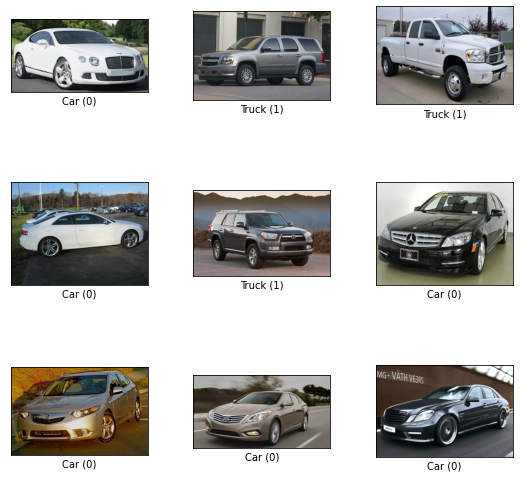

In [12]:
#$HIDE$
import matplotlib.pyplot as plt
tfds.show_examples(ds_train, ds_info);

## Step 2 - Define Pretrained Base ##

The pretrained model we'll use is called **VGG16**. Defining the model will download the pretrained weights.

In [14]:
from tensorflow.keras.applications import VGG16

pretrained_base = VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=[*SIZE, 3])
pretrained_base.trainable = False

58892288/58889256 [==============================] - 145s 2us/step


## Step 3 - Attach Head ##

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first `Dense` layer) followed by a layer to transform the outputs to a probability score for class 1, `Truck`. The `Flatten` layer transforms the multidimensional outputs of the base into the one dimensional inputs needed by the head.

In [15]:
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers

model = Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

## Step 4 - Train ##

Finally, we'll train the model. First, compile the model with the training parameters: an `optimizer`, a `loss` function, and any desired `metrics`. (Review Lesson 5 of *Introduction to Deep Learning* if this is unfamiliar.)

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(ds_train_,
                    validation_data=ds_valid_,
                    epochs=10)

Epoch 1/10
160/160 [==============================] - 54s 336ms/step - loss: 0.4511 - accuracy: 0.8007 - val_loss: 0.3071 - val_accuracy: 0.8810
Epoch 2/10
160/160 [==============================] - 38s 240ms/step - loss: 0.2622 - accuracy: 0.9038 - val_loss: 0.2465 - val_accuracy: 0.9006
Epoch 3/10
160/160 [==============================] - 39s 243ms/step - loss: 0.1998 - accuracy: 0.9287 - val_loss: 0.2306 - val_accuracy: 0.9071
Epoch 4/10
160/160 [==============================] - 38s 240ms/step - loss: 0.1602 - accuracy: 0.9427 - val_loss: 0.2104 - val_accuracy: 0.9123
Epoch 5/10
160/160 [==============================] - 38s 239ms/step - loss: 0.1266 - accuracy: 0.9605 - val_loss: 0.2035 - val_accuracy: 0.9155
Epoch 6/10
160/160 [==============================] - 38s 240ms/step - loss: 0.1032 - accuracy: 0.9709 - val_loss: 0.2032 - val_accuracy: 0.9133
Epoch 7/10
160/160 [==============================] - 38s 239ms/step - loss: 0.0814 - accuracy: 0.9805 - val_loss: 0.2013 - val_ac

## Step 5 - Evaluate ##

When training a neural network, it's always a good idea to examine the loss and metric plots. The `history` object contains this information in a dictionary `history.history`. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

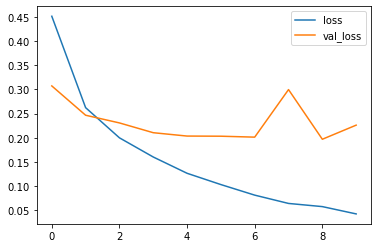

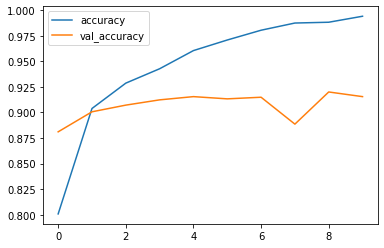

In [34]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

<!-- discuss convergence, over/underfitting -->

What do you see here? Notice that after epoch 6 the validation loss begins increasing even as the training loss continues to decrease. This is a sign of **overfitting**. It might mean that the VGG16 model is too big for this dataset. You'll use another model in the exercises that won't be as prone to this problem.

# Conclusion #

In this lesson, we learned about the structure of a convnet classifier: a **head** to act as a classifier atop of a **base** which performs the feature extraction.

The head, essentially, is an ordinary classifier like you learned about in the introductory course. For features, it uses those features extracted by the base. This is the basic idea behind CNN image classifiers: that we can attach a unit that performs feature engineering to the classifier itself.

This is one of the big advantages deep neural networks have over traditional machine learning models: given the right network structure, the deep neural net can learn how to engineer the features it needs to solve its problem.

In the remainder of this micro-course, we're going to explore this convolutional base.